In [1]:
import sys
import os
import gc

package_path = os.path.join(os.getcwd(), "packages/")
if package_path not in sys.path:
    sys.path.insert(0, package_path)

import PubChemHazardAPI
import PubChemBioactivityAPI
import PubChemIdentifiers
import PubMedAPI
import AssayData
import ChemblAPI
import CTXAPI

import LLMAnalysis # this involves loading a huggingface model (BioGPT-Large) so expect the import block to take a little while - also expect some loading bars. If it's bugging you just comment it out
                   # I will point out the single block that uses it later

from tqdm import tqdm
import time
import json

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from dotenv import load_dotenv


Stepping into a role as a risk-concerned toxicologist conducting a preliminary analysis of the potential hazard posed by some chemical...

It could be interesting to look at atrazine, a very common pesticide. 

I want to note: I focused a lot on information gathering and processing existing data because the product I saw seemed like it already had predictive models. Adding these as endpoints (ergo collecting the data to train them as endpoints) would be the sort of thing I as a risk-concerned toxicologist would want to consider during my assessment. Does the literature say it's scary? Does it show activity in in vitro NAMs? Will it absorb through the skin? Etc. Etc. I therefore selected tools and a workflow from this perspective. Please ask me any question you'd like about supervised machine learning if that is of specific interest.

If the assignment was directly a QSAR *or* a chemical without a large amount of data I would dive into read-across (automated by GenRA or an in-house similarity approach) and use the systems I developed and applied here to begin characterizing similar compounds that have data. 

In [2]:
print(os.getcwd())

C:\Users\Nate\Documents\Projects\2025\ChemicalToxAnalysis


In [3]:
CHEMICAL_NAME = 'atrazine'

load_dotenv()
CTX_API_KEY = os.getenv("CTX_API_KEY")
if not CTX_API_KEY:
    raise ValueError("API key not found. Please set CTX_API_KEY in your .env file.")

In [4]:
inchi_key = PubChemIdentifiers.inchi_from_name(CHEMICAL_NAME)
# I don't generally trust preferred names so I'm going to convert to Inchi for tracking purposes. In a production environment we would need to be careful in how we map preferred name to Inchikey
# Confining scope to handling compounds. Substances would require more upstream handling/thinking
pubchem_cid = PubChemIdentifiers.pubchem_cid_from_inchi(inchi_key)

In [5]:
assays = PubChemBioactivityAPI.pubchem_bioactivity_summary(pubchem_cid)
bioactivity_summary = PubChemBioactivityAPI.bioactivity_json_to_dframe(assays)
bioactivity_summary = bioactivity_summary.loc[bioactivity_summary['Activity Outcome'] == 'Active']

try: 
    with open(os.path.join(os.getcwd(), f"assay_desc_{pubchem_cid}.json"), "r") as fin:
        tox_assays = json.load(fin)
except:
    print("No JSON detected. Analyzing assays.")
    tox_assays = {}
    for aid in tqdm(bioactivity_summary['AID'], desc="Detecting Relevant Assays"):
        assay_desc = PubChemBioactivityAPI.assay_description(aid)
        relevance = AssayData.tox_keyword_hits(assay_desc)
        if relevance != None:
            tox_assays[aid] = {"keywords" : relevance, "desc" : assay_desc}
        # avoid angering pubchem gods - stick to < 5 requests / sec
        time.sleep(0.21)
    with open(os.path.join(os.getcwd(), f"assay_desc_{pubchem_cid}.json"), "w") as fout:
        json.dump(tox_assays, fout, indent=2)

BA_summary = AssayData.summarize_assay_data(tox_assays)
GHS_summary = PubChemHazardAPI.summarize_hazard_codes(PubChemHazardAPI.extract_ghs_hazard_codes(pubchem_cid))

print(BA_summary)
print(GHS_summary['GHS Definitions'])


No JSON detected. Analyzing assays.


Detecting Relevant Assays: 100%|███████████████████████████████████████████████████████| 36/36 [00:14<00:00,  2.48it/s]

{'developmental': 1, 'mutagen': 2, 'CYP': 3}
['Harmful if swallowed Acute toxicity, oral', 'May cause an allergic skin reaction Skin sensitization', 'Causes serious eye irritation Serious eye damage/eye irritation', 'Causes eye irritation Serious eye damage/eye irritation', 'May be harmful if inhaled Acute toxicity, inhalation', 'Suspected of damaging fertility or the unborn child Reproductive toxicity', 'May cause damage to organs Specific target organ toxicity, single exposure', 'May cause damage to organs through prolonged or repeated exposure Specific target organ toxicity, repeated exposure', 'Very toxic to aquatic life Hazardous to the aquatic environment, acute hazard', 'Very toxic to aquatic life with long lasting effects Hazardous to the aquatic environment, long-term hazard']


Extensive hazard code profile and activity in bioassays associated with CYP metabolism/activity, mutagens, and one developmental assay. It's enough that I'd want to pull up the abstracts and check how many of these indicate a true issue. The ecotox is noticeable.

In [6]:
tox_assays['1259392'] # pulling the 'developmental' record by its AID. It looks like activity in this assay might represent a genuine devtox concern, but it's hardly an in vivo study

{'keywords': ['developmental'],
 'desc': ['U.S. Tox21 Program',
  '',
  'National Center for Advancing Translational Sciences [NCATS]',
  'NIH Chemical Genomics Center [NCGC]',
  'U.S. Environmental Protection Agency [EPA]',
  'National Institutes of Environmental Health Sciences [NIEHS]',
  'National Toxicology Program [NTP]',
  'U.S. Food and Drug Administration [FDA]',
  '',
  'Tox21 Assay Overview:',
  '',
  'The sonic hedgehog (Shh) pathway is essential for normal embryonic development. Dysregulation of the Shh pathway can cause severe developmental defects in organs. Therefore chemicals that interfere with the pathway are potential developmental toxicants. A cell line designated 3T3Gli1-Luc (DMB/OARSA/CFSAN/FDA, Laurel, MD), a NIH/3T3 derived clone containing stably integrated Gli1-Luc reporter is used to detect chemical interference of the Shh pathway, by changes in the expression of the firefly Luc gene under the control of the Gli1 transcriptional response element. This cell l

In the context of further investigating the toxicology of this molecule I would also be interested in the scientific literature. The bioactivity data flagged developmental toxicity, so let's grab some abstracts from the past year with keywords 'atrazine', 'developmental', and 'toxicity'

In [7]:
pmids = PubMedAPI.get_pubmed_ids(CHEMICAL_NAME, keywords=['developmental', 'toxicity'], max_results=10)
first_abstract = PubMedAPI.get_abstract(pmids[0])
print(first_abstract)

1. Int J Mol Sci. 2024 Dec 5;25(23):13066. doi: 10.3390/ijms252313066.

Integrated Analysis of Neuroendocrine and Neurotransmission Pathways Following 
Developmental Atrazine Exposure in Zebrafish.

Stradtman SC(1), Swihart JN(1), Moore K(1), Akoro IN(1), Ahkin Chin Tai JK(1), 
Tamagno WA(1), Freeman JL(1).

Author information:
(1)School of Health Sciences, Purdue University, West Lafayette, IN 47907, USA.

Atrazine is an endocrine-disrupting herbicide, with exposure impacting adverse 
outcomes along multiple endocrine pathways. This study investigated the 
neuroendocrine system as the central target of atrazine toxicity, examining 
effects of early developmental exposures on neurohormones and genes associated 
with kisspeptin, hypothalamic, pituitary, and dopamine systems. Zebrafish were 
exposed to 0, 0.3, 3, or 30 ppb (µg/L) atrazine during two developmental time 
windows. For neurohormone assessments, exposure was ceased at the end of 
embryogenesis (72 h post-fertilization, hpf) a

Personally I have no issue reading the literature, but I recognize the point of this exercise is to be considering an agentic system. With this in mind I wanted to explore the utility of an LLM for getting simplied but representative summaries of the abstracts recovered from pubmed. Please note: this method is rough. I think there's promise but it requires development and validation outside the scope of this assignment, and more careful validation the LLM is consistently delivering a reliable summary. Honestly I just thought it was a fun idea to explore.

This function downloads and runs BioGPT-Large from HuggingFace so it will be memory and processor hungry. In a perfect world I'd have an api key to more advanced models, but they charge a corporate rate.

*If you commented out the LLM import earlier this block will not work. It will take a little while for the model to do its thing. Also the models are currently stochastic...there's a way to fix the seed for reproducibility but I would need to dig into it*

In [8]:
llm_key_findings = {}
for pmid in pmids:
    key_finding = LLMAnalysis.key_finding(PubMedAPI.get_abstract(pmid))
    llm_key_findings[pmid] = key_finding
    print(f"{pmid}\n {key_finding}\n")

39684776
 Developmental atrazine exposure affects the neuroendocrine system of zebrafish. However, the effects of atrazine are sex-specific, with the effects on neurohormones and genes associated with kisspeptin, hypothalamic, pituitary, and dopamine systems occurring in a sex-specific manner.

39226955
 reduced transcriptome analysis in zebrafish uncovers disruptors of spliceosome and ribosome biosynthesis.

39195672
 The results show that pesticides can cause thyroid dysfunction, even with an indirect toxicity mechanism from thyroid dysfunction to offspring.

38896413
 1. Environmental presence and toxicological outcomes of the herbicide pendimethalin in teleost fish. 2.0 24.

38815618
 ATR can affect the endocrine system. What is already known on this subject? • Atrazine (ATR) is a widely used herbicide and is found in the environment. • ATR can cause endocrine toxicity. What this study adds? • The present study systematically outlines the endocrine toxicity of ATR on the endocrine 

So some interesting results. It looks like the first, fifth and sixth might be most immediately relevant to atrazine.

In [9]:
gc.collect() # going to free up some RAM because that model is big and I found my script getting twitchy

109

In [10]:
print(PubMedAPI.get_abstract(pmids[4]))

1. Toxicology. 2024 Jun;505:153846. doi: 10.1016/j.tox.2024.153846. Epub 2024 May
 28.

Endocrine toxicity of atrazine and its underlying mechanisms.

Zhao H(1), Qian H(1), Cui J(1), Ge Z(1), Shi J(1), Huo Y(1), Zhang Y(2), Ye 
L(3).

Author information:
(1)Department of Occupational and Environmental Health, School of Public Health, 
Jilin University, Changchun, China.
(2)Department of Occupational and Environmental Health, School of Public Health, 
Jilin University, Changchun, China. Electronic address: jlzhangyz@163.com.
(3)Department of Occupational and Environmental Health, School of Public Health, 
Jilin University, Changchun, China. Electronic address: jlyelin@163.com.

Atrazine (ATR) is one of the most widely utilized herbicides globally and is 
prevalent in the environment due to its extensive use and long half-life. It can 
infiltrate the human body through drinking water, ingestion, and dermal contact, 
and has been recognized as an environmental endocrine disruptor. This st

In [11]:
print(PubMedAPI.get_abstract(pmids[5]))

1. Chemosphere. 2024 Jun;358:142080. doi: 10.1016/j.chemosphere.2024.142080. Epub
 2024 Apr 18.

Synergistic developmental effects of zebrafish exposed to combined 
perfluorooctanoic acid and atrazine.

Zhao X(1), Wang B(1), Song X(1), He L(1), Zhang W(1), Qian Y(1), Mu X(2), Qiu 
J(3).

Author information:
(1)Institute of Quality Standard and Testing Technology for Agro-Products, 
Chinese Academy of Agricultural Sciences, Key Laboratory of Agri-food Safety and 
Quality, Ministry of Agriculture and Rural Affairs, Beijing, 100081, China.
(2)Institute of Quality Standard and Testing Technology for Agro-Products, 
Chinese Academy of Agricultural Sciences, Key Laboratory of Agri-food Safety and 
Quality, Ministry of Agriculture and Rural Affairs, Beijing, 100081, China. 
Electronic address: muxiyan@caas.cn.
(3)Institute of Quality Standard and Testing Technology for Agro-Products, 
Chinese Academy of Agricultural Sciences, Key Laboratory of Agri-food Safety and 
Quality, Ministry of Agricu

Alright, so there's recent literary evidence of some potentially deleterious bioactivity and ecological toxicity. It also appears BioGPT-Large did a decent job extracting the key findings so that could probably be tuned into something pretty useful. If I were using some auto-toxicology dashboard I'd want those publications and summaries surfaced/available so I could dig deeper as part of a risk assessment.


Let's zero in on human toxicity. One of the first places I'd check is whether we know anything about its ADME (absorption, distribution, metabolism, excretion) to see if there's quantitative data on things like how much might permeate the skin. I will query ChemBL and its database of ADME activities. There are other resources (PKDB, httk) but I like ChemBL's focus on pharmacology so, for the purposes of this exercise, let's see if it offers any insight into atrazine.

In [12]:
chembl_id = ChemblAPI.chemblid_from_inchi(inchi_key)
assay_type = 'A'
organism = 'Homo sapiens'
types = ['log Kp', 'F', 'Vd', 'CL'] # logKp for skin permeability, F for bioavailability, Vd for volume of distribution, CL for clearance - this should give a good overview of expected ADME if there's data

adme_assays = ChemblAPI.chembl_ADME(chembl_id, organism)
clean_adme = ChemblAPI.clean_ADME(adme_assays, types)
clean_adme

,assay_chembl_id,assay_description,bao_endpoint,target_organism,target_pref_name,type,units,value
0,CHEMBL865441,Permeability in human skin,BAO_0000179,Homo sapiens,Homo sapiens,log Kp,cm/s,-5.56
3,CHEMBL925052,Permeability across human Skin,BAO_0000179,Homo sapiens,Skin,log Kp,None,-5.56


Skin permeability looks to be relatively low for this compound. That's good for something that's not intended for topical administration. It can't do damage if it doesn't get into the body.

Finally let use CTX API and ToxRef to see what in vivo toxicity data is there for the assessment. We'll apply a technique developed in EPA to consolidate that data into a quick reference benchmark that a toxicologist might use as an estimate of the dosage where chronic oral consumption could get bad. This is a core problem of toxicology: "How much of the poison makes it a poison?"

In [13]:
CTXAPI.get_dtxsid_from_inchikey(inchi_key, CTX_API_KEY)

'DTXSID9020112'

In [14]:
dtxsid = CTXAPI.get_dtxsid_from_inchikey(inchi_key, CTX_API_KEY) # the DTXSID is the core chemical identifier for most USEPA systems
cancer_data = CTXAPI.get_cancer_data(dtxsid, CTX_API_KEY)
print(cancer_data)

[{'id': 2680, 'source': 'EPA OPP', 'url': 'http://www.epa.gov/pesticides/carlist/', 'exposureRoute': '-', 'cancerCall': 'Not Likely to Be Carcinogenic in Humans', 'dtxsid': 'DTXSID9020112'}, {'id': 2681, 'source': 'IARC', 'url': 'https://monographs.iarc.who.int/list-of-classifications/', 'exposureRoute': '-', 'cancerCall': 'Group 3 - Not classifiable as to its carcinogenicity to humans', 'dtxsid': 'DTXSID9020112'}]


In [15]:
ctx_hazard = CTXAPI.get_hazard_data(dtxsid, CTX_API_KEY)
len(ctx_hazard)
pd.DataFrame(ctx_hazard).columns

Index(['id', 'year', 'source', 'priorityId', 'subsource', 'sourceUrl',
       'subsourceUrl', 'riskAssessmentClass', 'toxvalType', 'toxvalSubtype',
       'toxvalNumeric', 'toxvalNumericQualifier', 'toxvalUnits', 'studyType',
       'studyDurationClass', 'studyDurationValue', 'studyDurationUnits',
       'strain', 'sex', 'population', 'exposureMethod', 'exposureForm',
       'media', 'lifestage', 'generation', 'criticalEffect', 'detailText',
       'supercategory', 'speciesCommon', 'humanEcoNt', 'exposureRoute',
       'dtxsid'],
      dtype='object')

In [16]:
noncancer_hazard = pd.DataFrame(ctx_hazard)[['id', 'source', 'subsource', 'sourceUrl', 'riskAssessmentClass', 'toxvalType', 'toxvalNumeric', 'toxvalUnits', 'criticalEffect', 'speciesCommon', 'exposureRoute']]

To harmonize and aggregate the toxicology data for this compound into a consolidated benchmark human equivalent dose I'm going to use a technique that only a few folks, mostly EPA-internal, will know about. It is technically documented to the public but is *not* an official assessment product. I am using it because it's a beautiful way to bring together disparate toxicity data into a single summary number. I am happy to to speak about it more. The public *draft* of the method is available at https://www.epa.gov/system/files/documents/2024-12/dcap-report_bosc-review_508-compliant_final.pdf and is in the process of undergoing scientific panel review.

I will be using it to consolidate the information in the chronic, sub-chronic, and acute (short-term) studies. I'm also using a (very) simplified version for the sake of brevity in this exercise. Feel free to ask if you want the gory details and why I made the simplification decisions I did for this assignment.

What question does this help a toxicologist answer? There is now a popular toxicology paper (Aurisano et al., 2023) and a method developed by many EPA toxicologists on deriving human-equivalent benchmark doses that allows us to rapidly process *in vivo* toxicity data into a concise value that speaks to the chronic oral toxicity of a chemical. This is a major goal of many toxicity assessments, as it strikes directly to the answer to the question "How much of this can we allow in people's drinking water?"

In [17]:
df = noncancer_hazard.query(
    "source == 'ToxRefDB' and ((riskAssessmentClass == 'subchronic') or (riskAssessmentClass == 'developmental') or (riskAssessmentClass == 'chronic') or (riskAssessmentClass == 'short-term')) and ((toxvalType == 'NOAEL') or (toxvalType == 'LOAEL'))"
)

In [18]:
# See Table 4-1 of documentation for these conversion factors

duration_cf = {
    'chronic' : 1, 
    'subchronic' : (1/3), 
    'short-term' : (1/10)
}

species_cf = {
    "Mouse": (1/11.3),
    "Rat": (1/5.6),
    "Rabbit": (1/3.),
    "Dog": (1/1.7),
}

effectlevel_cf = {
    "LOAEL" : (1/3),
    "NOAEL" : 1,
}

In [19]:
df.to_csv(os.path.join(os.getcwd(), "tox_df.csv"))

In [20]:
import numpy as np

def compute_eBMDHED(row):
    duration = 1 if row["riskAssessmentClass"] == "developmental" else duration_cf.get(row["toxvalType"].lower(), 1)
    species = species_cf.get(row["speciesCommon"], 1)
    study = effectlevel_cf.get(row["toxvalType"], 1)
    return row["toxvalNumeric"] * study * species * duration

df.loc[:, "eBMDHED_mg_kg_day"] = df.apply(compute_eBMDHED, axis=1)
df['Log(BMDHED)'] = np.log10(df['eBMDHED_mg_kg_day'])


C:\Users\Nate\AppData\Local\Temp\ipykernel_19336\710382916.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "eBMDHED_mg_kg_day"] = df.apply(compute_eBMDHED, axis=1)
C:\Users\Nate\AppData\Local\Temp\ipykernel_19336\710382916.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Log(BMDHED)'] = np.log10(df['eBMDHED_mg_kg_day'])


In [21]:
lower_ci = df['Log(BMDHED)'].quantile(0.025)
upper_ci = df['Log(BMDHED)'].quantile(0.975)

I am personally a very visual scientist who would want a figure like this one served up to me to get an idea of the spread of the data from the collected studies. 

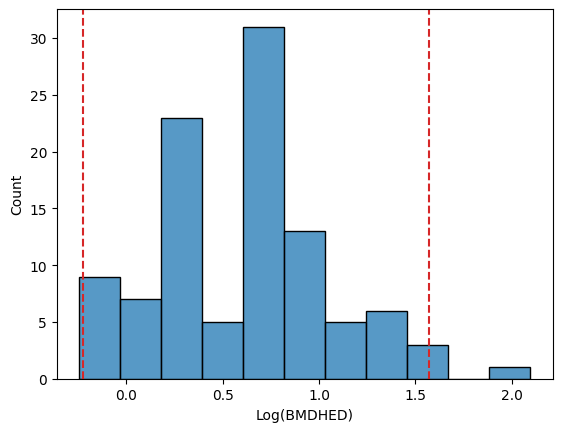

In [22]:
fig, ax = plt.subplots()
sns.histplot(df, x='Log(BMDHED)')
ax.axvline(lower_ci, linestyle="--", c="tab:red")
ax.axvline(upper_ci, linestyle="--", c="tab:red")
plt.show()

Finally, I would look at the 2.5th confidence interval to get a protective sense of the potential toxicity might be

In [23]:
protective_BMD = float(10**lower_ci)
print(protective_BMD)

0.5974100536182186


At this point we would start to apply uncertainty factors. I am not going to be this as uncertainty analysis is not especially prescriptive. Honestly there's a lot of scientific debate around that, and to quote my division director "uncertainty analysis is a bunch of old, cranky toxicologists arguing over how many times to divide the number". As usual, feel free to ask if you want to know more.

But as a starting point the human-equivalent chronic oral benchmark dose where 97.5% of studies said things would be fine was about 0.6 mg/kg/day. So...avoid drinking 0.6 mg/kg/day atrazine. And, again, uncertainty factors would bring this lower because we don't necessary trust the certainty of the database (divide by 10) or the endpoint conversion (have a bunch of toxicologists argue about whether or not to divide by 2 or 3). The uncertainty factors lower the dose to be more protective - regulating around where the science told us bad things will start to happen wouldn't be protective. There is uncertainty in our science, and the uncertainty factors are intended to protect against that.

Alright, let's check what the risk assessors might have said for their reference doses.

In [24]:
df = noncancer_hazard.query(
    "toxvalType == 'RfD'"
)

df

,id,source,subsource,sourceUrl,riskAssessmentClass,toxvalType,toxvalNumeric,toxvalUnits,criticalEffect,speciesCommon,exposureRoute
7497,378472,Cal OEHHA,California DPH,https://oehha.ca.gov/chemicals,chronic,RfD,0.006,mg/kg-day,-,Human (RA),oral
7522,377757,HEAST,-,https://cfpub.epa.gov/ncea/risk/recordisplay.c...,chronic,RfD,0.035,mg/kg-day,reduced weight gain,Human (RA),oral
7524,383868,IRIS,-,https://www.epa.gov/iris,chronic,RfD,0.035,mg/kg-day,Other:Decreased body weight gain,Human (RA),oral
7527,393612,OW Drinking Water Standards,EPA OW,https://www.epa.gov/ground-water-and-drinking-...,chronic,RfD,0.020,mg/kg-day,-,Human (RA),oral
7536,377640,Pennsylvania DEP ToxValues,Health Effects Assessment Summary Table (HEAST),https://www.dep.state.pa.us/toxicity/ToxicityV...,chronic,RfD,0.035,mg/kg-day,-,Human (RA),-
7540,378430,RSL,ATSDR,https://www.epa.gov/risk/regional-screening-le...,chronic,RfD,0.003,mg/kg-day,-,Human (RA),-
7543,391888,RSL,ATSDR,https://www.epa.gov/risk/regional-screening-le...,chronic,RfD,0.003,mg/kg-day,-,Human (RA),oral


So, we see they probably applied some uncertainty factors or didn't completely align with what our database calibrated approach yielded, but generally there's concordance. I suspect that first study used a similar benchmark dose (~0.6 mg/kg/day) and divided by 10 for database uncertainty and maybe another 10 for interspecies variation? I'd have to track down the risk assessment. But notice how the RfDs are all close to our benchmark dose divided by some combination of "divide by 10/3/2" that we would apply during uncertainty analysis. That tells me the database method actually did a pretty spiffy job. 

To review:

I selected the chemical atrazine due to its use as a common pesticide. The assigment was to select and/or develop some tools for characterizing the properties of the chemical. Given the premise of Human Chemical, I decided that simulating a workflow examining properties that a toxicity risk assessor might care about: the bioactivities, in vivo activities, and ADME properties.

Tool Set 1: PubChem and Bioactivity data - I built a small wrapper for PubChem's APIs to access bioactivity data and flag it by search terms that might indicate activities of concern. It flagged developmental toxicity, which is definitely of interest.

Tool Set 2: PubMed, the literature, and language models - I built a small wrapper for manipulating some of PubMed's APIs to grab recent literature on atrazine and applied an LLM (BioGPT-3) to quickly generate a short statement of key findings. Based on this I was able to hone down to some studies that were relevant to the potential developmental, endocrinal, and ecological hazard. In a risk-assessment context I would want to take a look at those studies because they could provide new sources of data or information.

Tool Set 3: Chembl, ADME properties - I built a small wrapper for accessing ChemBL (a data source for pharmaceuticals and therefore containing ADME information) to see if I could find anything on atrazine's absorption, distribution, metabolism, or excretion. It was a modest hit, but we did learn that atrazine has a relatively low (~-5) LogKp, which typically indicates it isn't extremely well absorbed by the skin. So maybe less of a concern for folks spraying down the crops if they're wearing masks (we'd need to dig deeper into inhalation data).

Tool Set 4: ToxRef, DCAP, CTX APIs - I built a small wrapper for accessing the CTX APIs to gather information on the in vivo tox data that is currently public. To help interpret these collections, I applied a method very recently proposed by EPA for using database information to consolidate a single benchmark dose of the oral chronic toxicity of atrazine, providing insight into how concerned I might be about it entering drinking water or being eating along with the apples. We skipped uncertainty factor analysis because I don't have a sufficiently cranky toxicologist to argue about which ones to use, but there are ways to do it. Finally, we were also able to access the reference doses (RfD) in ToxRef which gives us direct knowledge of what risk assessors have concluded are the official toxicological values of atrazine.

There's a lot more that could be done, but I need to stop somewhere. The assignment seemed to push toward a cheminformatics approach in terms of characterizing toxicologically interesting properties, so I went with tools along those lines. If there's a desire for a more QSAR-driven approach or an examination of my accumen with machine learning, I am happy to converse or oblige.